# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from datetime import datetime
import joblib

from epics import ca
ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "log_weighted_sum_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [6]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [7]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [82]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = 111,
    add_noise = True,
    calculate_over_noise= True,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5
   )

xrange_plot = [x/5 for x in cp.xrange]
yrange_plot = [y/5 for y in cp.yrange]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 5, nbins_v = cp.nbins_v // 5)#xrange=xrange_plot, yrange=yrange_plot)#, )


In [83]:
cp.nbins_h

1024

In [84]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [85]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['fwhm', 'log_weighted_sum_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [86]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5


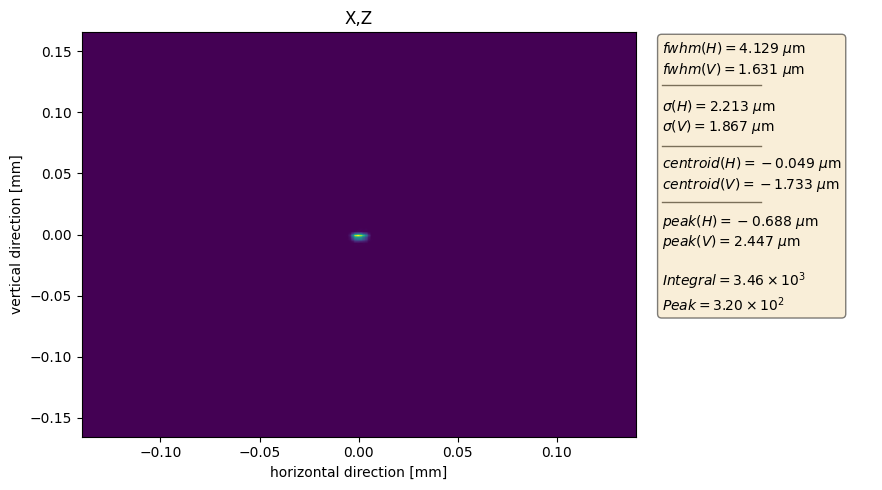

In [87]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [88]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 4.423e-03
Focused beam system log_weighted_sum_intensity: 1.224e+01


In [89]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [90]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-180.0, -184.5, 0.17058733853924987, -0.0148, 434.69999999999993, 0.17348733853924986, 0.0086]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-11.950760674508242, -23.506086790895175, 0.0012896417000977998, -0.007433697601740542, 15.704870608929916, 0.0015984380166833654, 0.00857906599203137]


0.5 0.5


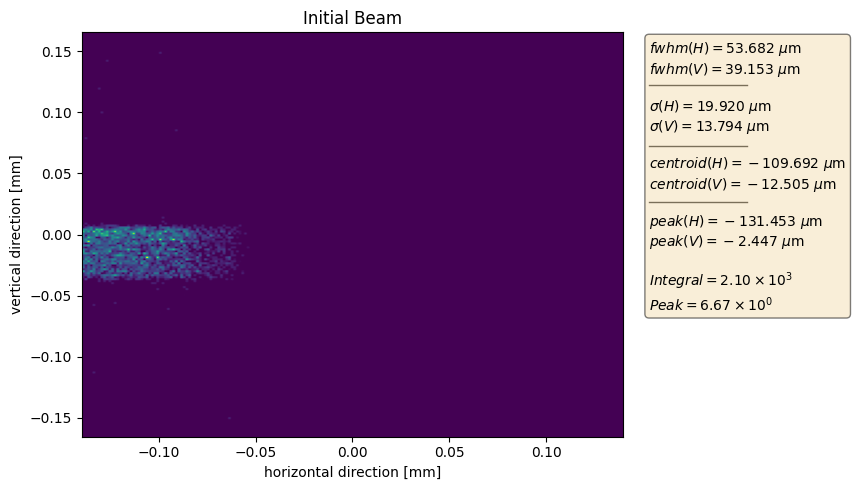

Perturbed beam system fwhm: 8.734e-02
Perturbed beam system log_weighted_sum_intensity: 1.224e+01


In [91]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

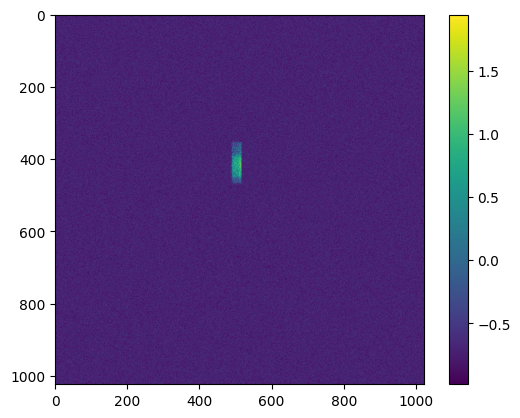

In [92]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [93]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS

In [94]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

0.5 0.5


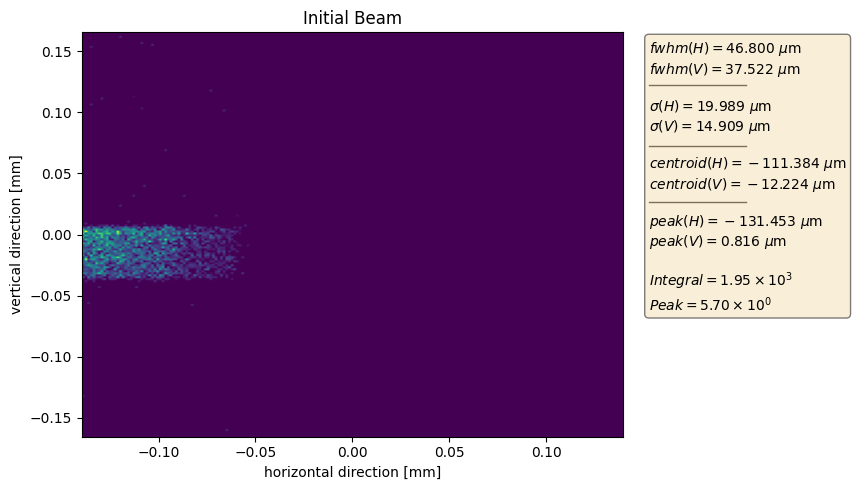

In [95]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [96]:
hist_pert.data_2D.max()

7.0073475974228785

In [80]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.403e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01


In [58]:
opt_params = OptimizationParameters()

In [59]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

0.5 0.5


In [60]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [61]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-05-09 14:51:33,297] A new study created in memory with name: no-name-fe8870d2-3542-4624-8400-22f83fc039c6


In [62]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-09 14:51:44,374] Trial 0 finished with values: [1.4018946178626535, 10.8552521921899] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:51:53,093] Trial 1 finished with values: [2.1729275228576386, 10.855492894447016] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:01,723] Trial 2 finished with values: [2.1729275228576386, 10.856401078231803] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:10,184] Trial 3 finished with values: [2.1729275228576386, 10.862952610789499] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:18,715] Trial 4 finished with values: [0.05493996190445061, 10.855825521772651] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:27,071] Trial 5 finished with values: [1.4016346553550518, 10.855194148373846] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:35,806] Trial 6 finished with values: [1.4012917325069305, 10.855368052093116] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:44,082] Trial 7 finished with values: [2.1729275228576386, 10.855431481335678] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:52:52,739] Trial 8 finished with values: [0.09012211259298451, 10.855102288738971] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


0.5 0.5
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:53:01,539] Trial 9 finished with values: [1.401713779482914, 10.862054086584864] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:53:12,624] Trial 10 finished with values: [0.06546678099664337, 10.855722687714604] and parameters: {'hb_1': 16.0, 'hb_2': 7.0, 'hb_pitch': 0.0019, 'hb_trans': -0.000899999999999998, 'vb_bender': 2.0, 'vb_pitch': -0.00118, 'vb_trans': -0.0272}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:53:23,730] Trial 11 finished with values: [1.4015630630093943, 10.855402179985107] and parameters: {'hb_1': 14.0, 'hb_2': -3.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0009999999999999974, 'vb_bender': 4.0, 'vb_pitch': -0.00158, 'vb_trans': -0.0197}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:53:34,690] Trial 12 finished with values: [0.062295576332243266, 10.855144086890354] and parameters: {'hb_1': 18.0, 'hb_2': 10.0, 'hb_pitch': 0.0019, 'hb_trans': -0.010199999999999997, 'vb_bender': -7.0, 'vb_pitch': -0.00146, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-09 14:53:46,099] Trial 13 finished w

0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:53:57,381] Trial 14 finished with values: [0.8179777167906259, 10.856108652344954] and parameters: {'hb_1': 16.0, 'hb_2': 3.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0005000000000000039, 'vb_bender': -8.0, 'vb_pitch': -0.0009, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:54:08,662] Trial 15 finished with values: [0.04232854028035458, 10.855841082703108] and parameters: {'hb_1': 18.0, 'hb_2': 10.0, 'hb_pitch': 0.0018, 'hb_trans': -0.007799999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.002, 'vb_trans': -0.0298}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:54:22,113] Trial 16 finished with values: [1.660831498925229, 10.855329663015802] and parameters: {'hb_1': 13.0, 'hb_2': 10.0, 'hb_pitch': 0.0019, 'hb_trans': -0.005499999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.002, 'vb_trans': -0.0275}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:54:31,970] Trial 17 finished with values: [0.06937514252519109, 10.855187623889655] and parameters: {'hb_1': 25.0, 'hb_2': 7.0, 'hb_pitch': 0.0018, 'hb_trans': -0.004299999999999998, 'vb_bender': -4.0, 'vb_pitch': -0.00166, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:54:43,466] Trial 18 finished with values: [0.07480248772875199, 10.854907592095845] and parameters: {'hb_1': 21.0, 'hb_2': 4.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0026999999999999975, 'vb_bender': -6.0, 'vb_pitch': -0.00182, 'vb_trans': -0.0278}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:54:53,582] Trial 19 finished with values: [0.8567715222894877, 10.854552323056874] and parameters: {'hb_1': 14.0, 'hb_2': 18.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.001899999999999999, 'vb_bender': -2.0, 'vb_pitch': -0.0006799999999999998, 'vb_trans': -0.024}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:55:03,914] Trial 20 finished with values: [0.06215624999999977, 10.854863802140951] and parameters: {'hb_1': 20.0, 'hb_2': 14.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.005400000000000002, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': -0.0281}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:55:16,519] Trial 21 finished with values: [0.061336435046064716, 10.85480249436305] and parameters: {'hb_1': 21.0, 'hb_2': 16.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.004299999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00118, 'vb_trans': -0.027}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:55:30,218] Trial 22 finished with values: [0.10757501725948657, 10.855088382056175] and parameters: {'hb_1': 21.0, 'hb_2': 0.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.015700000000000006, 'vb_bender': 1.0, 'vb_pitch': -0.002, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:55:42,181] Trial 23 finished with values: [0.026562234603453402, 10.854820099175491] and parameters: {'hb_1': 19.0, 'hb_2': 11.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.008799999999999999, 'vb_bender': 5.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:55:54,270] Trial 24 finished with values: [0.011440103870267053, 10.85455176688407] and parameters: {'hb_1': 19.0, 'hb_2': 22.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.0076999999999999985, 'vb_bender': 9.0, 'vb_pitch': -0.00074, 'vb_trans': -0.0254}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:56:07,462] Trial 25 finished with values: [0.027894210422552752, 10.855222553037198] and parameters: {'hb_1': 19.0, 'hb_2': 13.0, 'hb_pitch': 0.0013, 'hb_trans': -0.004699999999999999, 'vb_bender': 6.0, 'vb_pitch': -0.00092, 'vb_trans': -0.0241}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:56:20,242] Trial 26 finished with values: [1.4013934876016354, 10.854810220138551] and parameters: {'hb_1': 23.0, 'hb_2': 24.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.010099999999999998, 'vb_bender': 6.0, 'vb_pitch': -0.00076, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:56:34,231] Trial 27 finished with values: [0.040633251115206055, 10.855117546809062] and parameters: {'hb_1': 17.0, 'hb_2': 20.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.004299999999999998, 'vb_bender': 6.0, 'vb_pitch': -0.00092, 'vb_trans': -0.0283}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:56:47,489] Trial 28 finished with values: [0.03364831687492875, 10.855273082148713] and parameters: {'hb_1': 17.0, 'hb_2': 19.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.015399999999999999, 'vb_bender': 7.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.024599999999999997}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:56:59,212] Trial 29 finished with values: [0.06713119915799644, 10.854929195308342] and parameters: {'hb_1': 19.0, 'hb_2': 5.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0059000000000000025, 'vb_bender': -2.0, 'vb_pitch': -0.00164, 'vb_trans': -0.0266}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:57:13,043] Trial 30 finished with values: [0.03306635433582744, 10.855559609553026] and parameters: {'hb_1': 17.0, 'hb_2': 20.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.005699999999999997, 'vb_bender': 12.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.024}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:57:26,991] Trial 31 finished with values: [0.043650612556554946, 10.855504522955167] and parameters: {'hb_1': 19.0, 'hb_2': 15.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.008499999999999997, 'vb_bender': -1.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': -0.026099999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:57:39,821] Trial 32 finished with values: [0.03230406022667882, 10.854968757993543] and parameters: {'hb_1': 18.0, 'hb_2': 21.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0022000000000000006, 'vb_bender': 4.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0248}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:57:52,944] Trial 33 finished with values: [2.1729275228576386, 10.855018246167598] and parameters: {'hb_1': 24.0, 'hb_2': 5.0, 'hb_pitch': 0.0015, 'hb_trans': 0.006600000000000002, 'vb_bender': -11.0, 'vb_pitch': -0.00196, 'vb_trans': -0.025599999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:58:06,307] Trial 34 finished with values: [0.015173655035254512, 10.854395954190172] and parameters: {'hb_1': 18.0, 'hb_2': 20.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.004799999999999999, 'vb_bender': 9.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': -0.0278}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:58:19,649] Trial 35 finished with values: [0.07095149271754343, 10.854269810651173] and parameters: {'hb_1': 18.0, 'hb_2': 4.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.011600000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.00056, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:58:34,420] Trial 36 finished with values: [0.07467827847425834, 10.85591100919072] and parameters: {'hb_1': 18.0, 'hb_2': 11.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.020300000000000006, 'vb_bender': 8.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.024399999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:58:46,964] Trial 37 finished with values: [1.4016346553550518, 10.855655708912007] and parameters: {'hb_1': 15.0, 'hb_2': 0.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.007200000000000005, 'vb_bender': 3.0, 'vb_pitch': 0.0014000000000000002, 'vb_trans': -0.024999999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:58:59,275] Trial 38 finished with values: [1.6618453734225618, 10.854673509404796] and parameters: {'hb_1': 20.0, 'hb_2': 2.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.0040000000000000036, 'vb_bender': -1.0, 'vb_pitch': -0.00084, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:59:12,537] Trial 39 finished with values: [0.063183385456573, 10.854416942566518] and parameters: {'hb_1': 17.0, 'hb_2': 8.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.007100000000000002, 'vb_bender': 4.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.03}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:59:24,425] Trial 40 finished with values: [0.043650612556554946, 10.855903705460351] and parameters: {'hb_1': 19.0, 'hb_2': -23.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.00010000000000000286, 'vb_bender': -1.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0292}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:59:37,144] Trial 41 finished with values: [1.3905321561571737, 10.855325770632522] and parameters: {'hb_1': 15.0, 'hb_2': -16.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.026300000000000004, 'vb_bender': 5.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.014099999999999998}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 14:59:49,378] Trial 42 finished with values: [1.4019963292007134, 10.854594347571933] and parameters: {'hb_1': -13.0, 'hb_2': -2.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.022600000000000002, 'vb_bender': -1.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.0075}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:00:02,543] Trial 43 finished with values: [0.0335599139192223, 10.854545108204617] and parameters: {'hb_1': -12.0, 'hb_2': 12.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.012400000000000001, 'vb_bender': 5.0, 'vb_pitch': -0.0015, 'vb_trans': 0.005400000000000002}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:00:16,466] Trial 44 finished with values: [1.4016346553550518, 10.855227698413394] and parameters: {'hb_1': -11.0, 'hb_2': 3.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.010300000000000004, 'vb_bender': 3.0, 'vb_pitch': -0.00134, 'vb_trans': -0.004699999999999999}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:00:31,331] Trial 45 finished with values: [1.4015630630093943, 10.855027405082524] and parameters: {'hb_1': -12.0, 'hb_2': 18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0092, 'vb_bender': 5.0, 'vb_pitch': -0.00134, 'vb_trans': 0.012500000000000004}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:00:40,620] Trial 46 finished with values: [0.08085810272247836, 10.854555105316587] and parameters: {'hb_1': 17.0, 'hb_2': 5.0, 'hb_pitch': 0.001, 'hb_trans': 0.0148, 'vb_bender': 3.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0272}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:00:53,427] Trial 47 finished with values: [1.4019963292007134, 10.855279842129317] and parameters: {'hb_1': 0.0, 'hb_2': 23.0, 'hb_pitch': 0.0005, 'hb_trans': 0.024900000000000005, 'vb_bender': -2.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0243}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:01:05,704] Trial 48 finished with values: [1.401499003600172, 10.854806357688531] and parameters: {'hb_1': 14.0, 'hb_2': -10.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.011500000000000003, 'vb_bender': 5.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.023399999999999997}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:01:18,685] Trial 49 finished with values: [1.6649307158663424, 10.854408898239603] and parameters: {'hb_1': 16.0, 'hb_2': 23.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0216, 'vb_bender': -12.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.028499999999999998}. 


0.5 0.5


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_59251/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


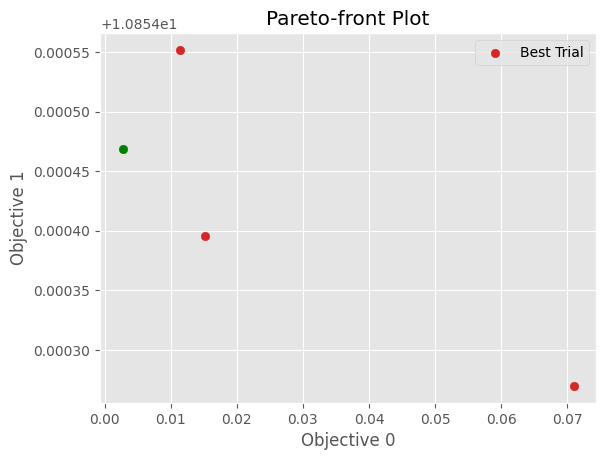

In [63]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [64]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-2.0860457038042104 51769.25746760019
-1.8036244212599901 51761.19178851702
-0.26120030308137654 51754.66286040175


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.011440103870267053, 10.85455176688407]


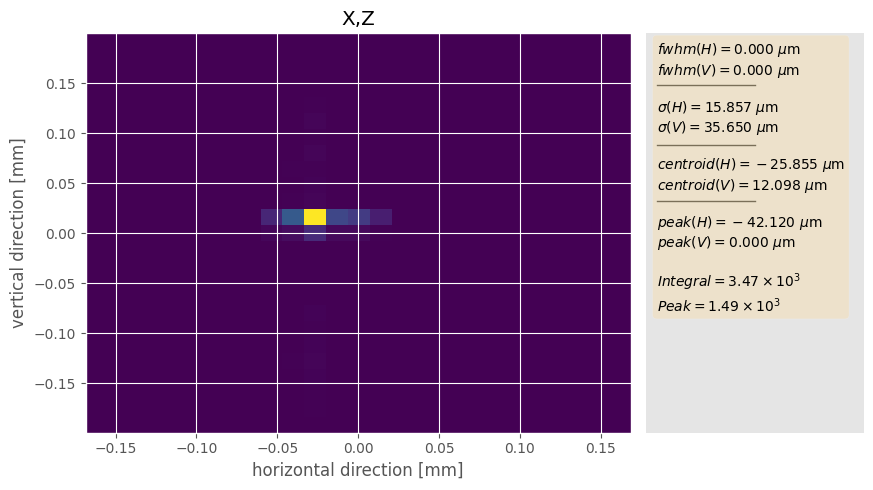

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.015173655035254512, 10.854395954190172]


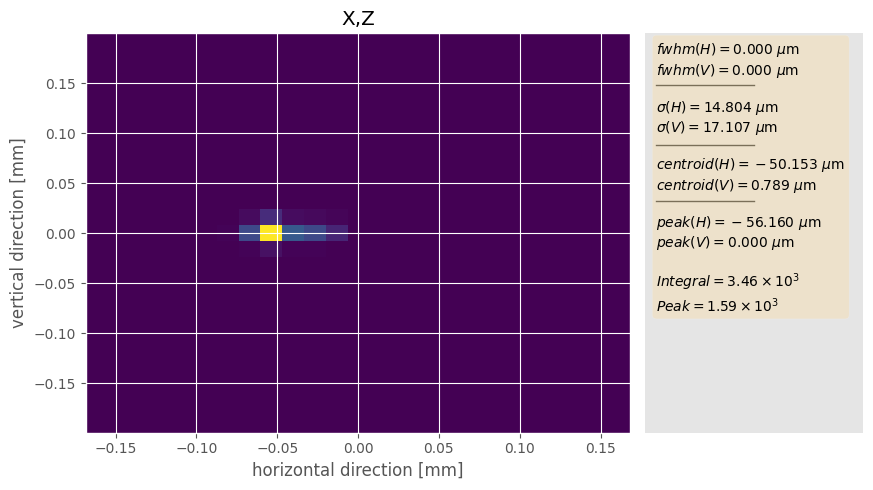

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.07095149271754343, 10.854269810651173]


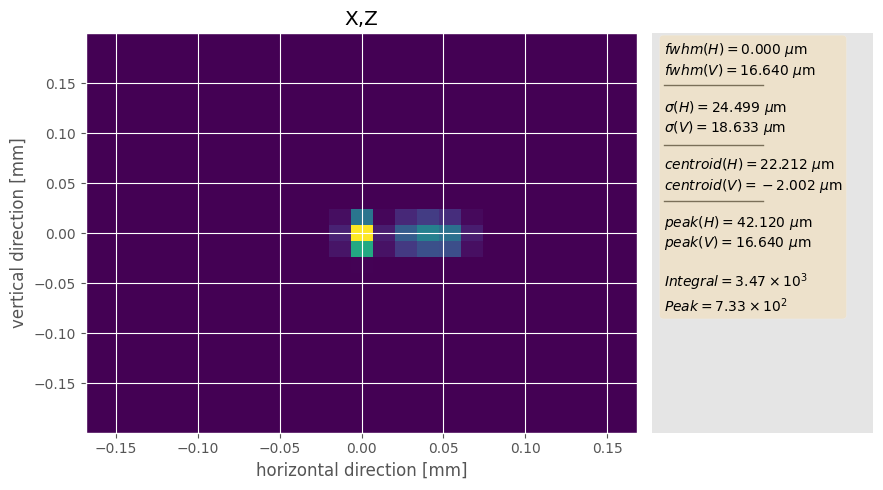

In [65]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

In [66]:
opt_trial.trials(20)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:03:35,861] Trial 50 finished with values: [1.4012615814302036, 10.854954199052862] and parameters: {'hb_1': -19.0, 'hb_2': 0.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.014700000000000005, 'vb_bender': 13.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.019100000000000006}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:03:49,038] Trial 51 finished with values: [1.4016346553550518, 10.85531069488267] and parameters: {'hb_1': -16.0, 'hb_2': 16.0, 'hb_pitch': 0.0, 'hb_trans': -0.0007999999999999986, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.009600000000000004}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:04:01,705] Trial 52 finished with values: [0.01467569339290304, 10.854776438608885] and parameters: {'hb_1': -14.0, 'hb_2': 11.0, 'hb_pitch': 0.0013, 'hb_trans': 0.023100000000000002, 'vb_bender': 8.0, 'vb_pitch': -0.00104, 'vb_trans': 0.004700000000000003}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:04:14,693] Trial 53 finished with values: [0.15660848583161938, 10.856464195608629] and parameters: {'hb_1': 16.0, 'hb_2': -17.0, 'hb_pitch': 0.0018, 'hb_trans': 0.024600000000000004, 'vb_bender': 8.0, 'vb_pitch': -0.00136, 'vb_trans': -0.0294}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:04:27,390] Trial 54 finished with values: [1.4018946178626535, 10.854939936156141] and parameters: {'hb_1': 14.0, 'hb_2': 1.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.027000000000000003, 'vb_bender': 0.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0002999999999999982}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:04:39,872] Trial 55 finished with values: [1.4012615814302036, 10.85499900863635] and parameters: {'hb_1': -13.0, 'hb_2': 22.0, 'hb_pitch': 0.0015, 'hb_trans': 0.016, 'vb_bender': 9.0, 'vb_pitch': -0.0017000000000000001, 'vb_trans': 0.0025000000000000022}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:04:54,345] Trial 56 finished with values: [1.4016346553550518, 10.855020001468755] and parameters: {'hb_1': -15.0, 'hb_2': 25.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.020800000000000006, 'vb_bender': 3.0, 'vb_pitch': -0.00058, 'vb_trans': 0.0015000000000000013}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:05:07,547] Trial 57 finished with values: [0.03538108660092976, 10.854644133198583] and parameters: {'hb_1': 17.0, 'hb_2': 20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.006099999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.0266}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:05:20,368] Trial 58 finished with values: [0.022880207740534106, 10.854244633900908] and parameters: {'hb_1': 20.0, 'hb_2': 18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.015599999999999998, 'vb_bender': 19.0, 'vb_pitch': -0.00042, 'vb_trans': -0.0219}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:05:33,957] Trial 59 finished with values: [1.4012615814302036, 10.854689043417451] and parameters: {'hb_1': -12.0, 'hb_2': -1.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.013999999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.0009, 'vb_trans': 0.0050000000000000044}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:05:42,783] Trial 60 finished with values: [0.10374439108520782, 10.855590184280857] and parameters: {'hb_1': 17.0, 'hb_2': 7.0, 'hb_pitch': 0.001, 'hb_trans': 0.026500000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0259}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:05:55,124] Trial 61 finished with values: [1.6620535032471753, 10.858470595015687] and parameters: {'hb_1': 22.0, 'hb_2': 12.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.011700000000000002, 'vb_bender': 6.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.015399999999999999}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:06:08,961] Trial 62 finished with values: [0.014090858991875019, 10.854914933601092] and parameters: {'hb_1': 18.0, 'hb_2': 15.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011499999999999996, 'vb_bender': 15.0, 'vb_pitch': -0.00042, 'vb_trans': -0.0253}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:06:21,193] Trial 63 finished with values: [0.05493996190445061, 10.855660068441537] and parameters: {'hb_1': 21.0, 'hb_2': 21.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0013999999999999985, 'vb_bender': 16.0, 'vb_pitch': 0.0, 'vb_trans': -0.0194}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:06:34,591] Trial 64 finished with values: [1.4015630630093943, 10.855584121227436] and parameters: {'hb_1': -10.0, 'hb_2': 5.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.008700000000000006, 'vb_bender': 4.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.015399999999999999}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:06:47,587] Trial 65 finished with values: [1.6607862222382868, 10.85468050197588] and parameters: {'hb_1': 7.0, 'hb_2': 11.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.021800000000000007, 'vb_bender': -9.0, 'vb_pitch': -0.00084, 'vb_trans': -0.0032999999999999974}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:07:01,398] Trial 66 finished with values: [0.0202659818901689, 10.854652607765672] and parameters: {'hb_1': 20.0, 'hb_2': 23.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.005899999999999999, 'vb_bender': 18.0, 'vb_pitch': 0.0009200000000000002, 'vb_trans': -0.022799999999999997}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:07:14,688] Trial 67 finished with values: [0.019125057444766596, 10.854919803152272] and parameters: {'hb_1': 19.0, 'hb_2': 14.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.008999999999999998, 'vb_bender': 20.0, 'vb_pitch': -0.00158, 'vb_trans': -0.0237}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:07:29,358] Trial 68 finished with values: [0.011440103870267053, 10.855418818449863] and parameters: {'hb_1': 19.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0211, 'vb_bender': 19.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': -0.022799999999999997}. 


0.5 0.5


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-09 15:07:43,521] Trial 69 finished with values: [2.1729275228576386, 10.855930719692166] and parameters: {'hb_1': 3.0, 'hb_2': 1.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.004700000000000003, 'vb_bender': -17.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': -0.014899999999999998}. 


0.5 0.5


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_59251/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


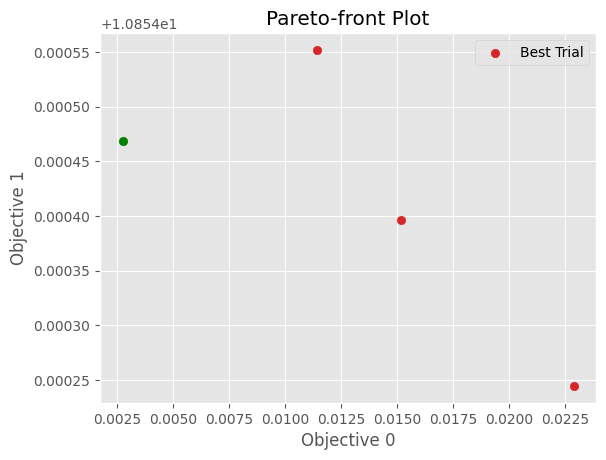

In [67]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [68]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-2.0860457038042104 51769.25746760019
-1.8036244212599901 51761.19178851702
-1.3929268189615875 51753.35986258248


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.011440103870267053, 10.85455176688407]


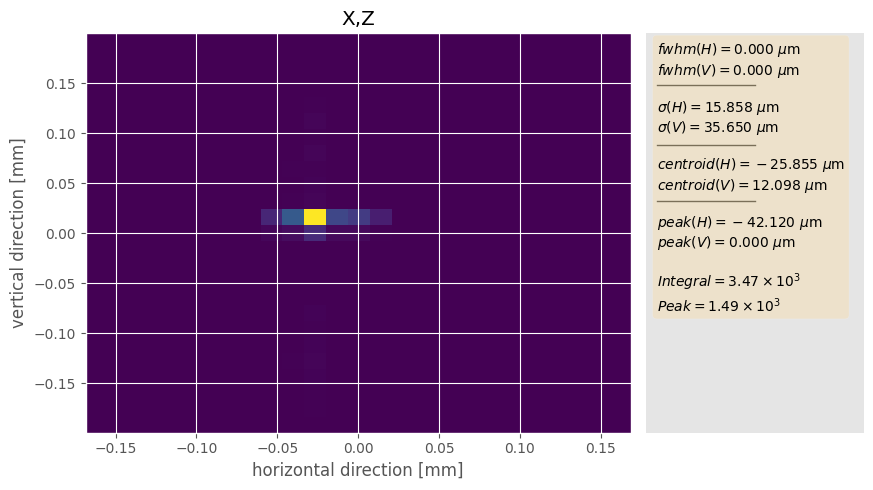

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.015173655035254512, 10.854395954190172]


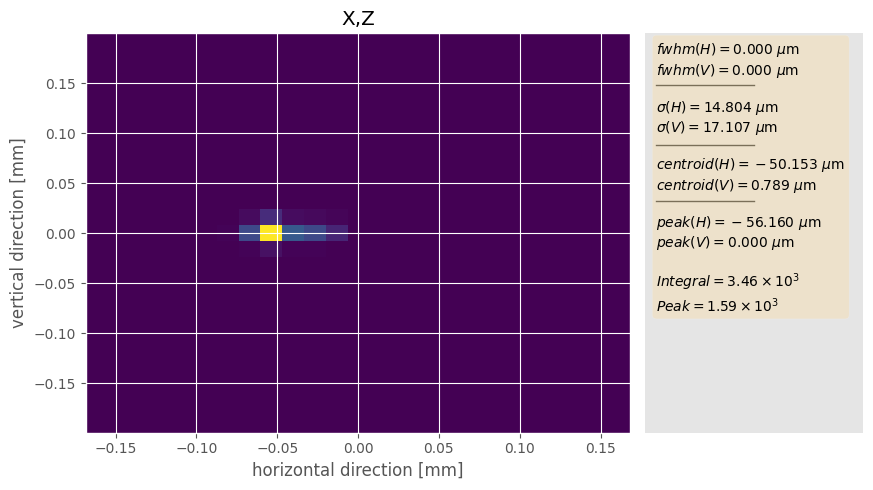

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
0.5 0.5
[0.022880207740534106, 10.854244633900908]


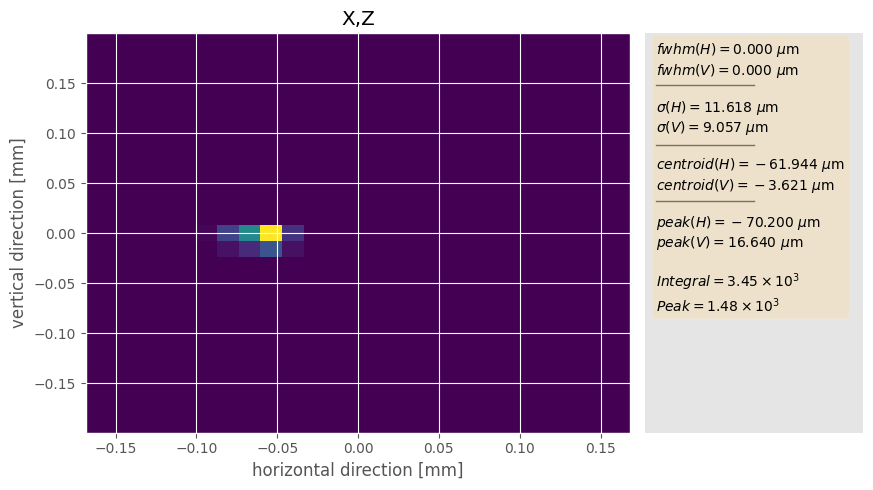

In [69]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()